<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/07_Transfer_learning_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow: Feature etraction

In [1]:
!nvidia-smi

Sun Oct 24 12:12:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Downloading the Data

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2021-10-24 12:14:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   158MB/s    in 1.0s    

2021-10-24 12:14:22 (158 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [6]:
import os

for dirpath, dirname, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filenames)} in {dirpath}")

There are 2 directories and 0 in 10_food_classes_10_percent
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 in 10_food_classes_10_percent/train/hamburger
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_f

## Creating the Data loaders

In [7]:
# create train and test data generation and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [9]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [11]:
images, labels = train_data_10_percent.next()
len(images), len(labels)

(32, 32)

### Callbacks

In [27]:
# Creating a TensorBoard callback function
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving TensorBoard log files to :{log_dir}")
  return tensorboard_callback

### Creating Model from tensorflow HUB

* Efficient url :- "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
* resnet url:- "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [29]:
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [16]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [21]:
# modelfunction

def create_model(model_url, num_classes=10):

  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create the model
  model = tf.keras.Sequential([
                               feature_extraction_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model
  

In [22]:
# Create Resnet Model
resnet_model = create_model(model_url=resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
#Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [28]:
#Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps = len(test_data),
                                    callbacks= [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="resnet50V2")])

saving TensorBoard log files to :tensorflow_hub/resnet50V2/20211024-133911
Epoch 1/5
24/24 [==============================] - 59s 1s/step - loss: 1.8652 - accuracy: 0.4013 - val_loss: 1.1626 - val_accuracy: 0.6348
Epoch 2/5
24/24 [==============================] - 22s 932ms/step - loss: 0.8933 - accuracy: 0.7240 - val_loss: 0.8620 - val_accuracy: 0.7352
Epoch 3/5
24/24 [==============================] - 21s 912ms/step - loss: 0.6166 - accuracy: 0.8240 - val_loss: 0.7582 - val_accuracy: 0.7596
Epoch 4/5
24/24 [==============================] - 21s 911ms/step - loss: 0.4764 - accuracy: 0.8747 - val_loss: 0.7135 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 21s 913ms/step - loss: 0.3818 - accuracy: 0.9093 - val_loss: 0.6835 - val_accuracy: 0.7764


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

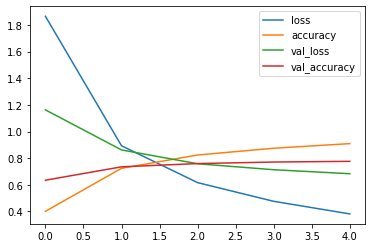

In [31]:
pd.DataFrame(resnet_history.history).plot()

In [32]:
# Plot the training and Validation curves seperatley

def plot_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs= range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

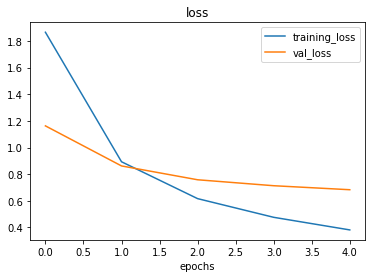

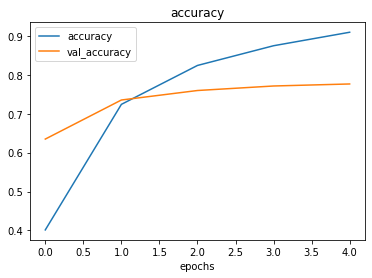

In [33]:
plot_curves(resnet_history)

In [35]:
# Creating a efficientnet model
efficientnet_model = create_model(model_url=efficient_url,
                            num_classes = train_data_10_percent.num_classes)

In [36]:
#Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [39]:
#Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                    epochs=10,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps = len(test_data),
                                    callbacks= [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="efficientnetb0")])

saving TensorBoard log files to :tensorflow_hub/efficientnetb0/20211024-135757
Epoch 1/10
24/24 [==============================] - 21s 899ms/step - loss: 0.4447 - accuracy: 0.9067 - val_loss: 0.5153 - val_accuracy: 0.8640
Epoch 2/10
24/24 [==============================] - 19s 817ms/step - loss: 0.3918 - accuracy: 0.9173 - val_loss: 0.4909 - val_accuracy: 0.8652
Epoch 3/10
24/24 [==============================] - 19s 812ms/step - loss: 0.3476 - accuracy: 0.9307 - val_loss: 0.4708 - val_accuracy: 0.8680
Epoch 4/10
24/24 [==============================] - 19s 798ms/step - loss: 0.3127 - accuracy: 0.9427 - val_loss: 0.4563 - val_accuracy: 0.8716
Epoch 5/10
24/24 [==============================] - 18s 797ms/step - loss: 0.2826 - accuracy: 0.9573 - val_loss: 0.4442 - val_accuracy: 0.8716
Epoch 6/10
24/24 [==============================] - 18s 791ms/step - loss: 0.2564 - accuracy: 0.9627 - val_loss: 0.4330 - val_accuracy: 0.8768
Epoch 7/10
24/24 [==============================] - 18s 790ms/s

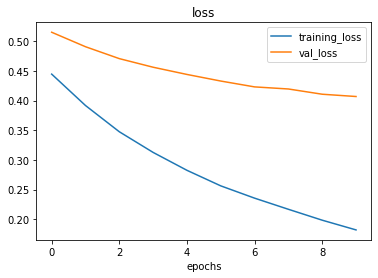

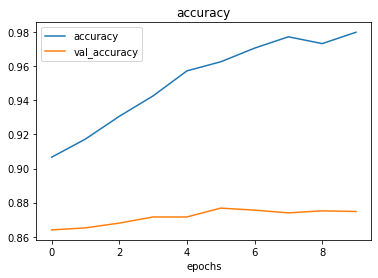

In [42]:
plot_curves(efficientnet_history)